In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Load data
deceased_path = "/content/drive/MyDrive/Gladyshev/data/imdb_all_deceased_with_age.csv"
longitudinal_path = "/content/drive/MyDrive/Gladyshev/data/longitudinal_stats_cleaned_rebuilt.csv"
output_path = "/content/drive/MyDrive/Gladyshev/data/longitudinal_imdb_ids.csv"

deceased_df = pd.read_csv(deceased_path)
longitudinal_df = pd.read_csv(longitudinal_path)

# Print column names
print("Deceased columns:", deceased_df.columns.tolist())
print("Longitudinal columns:", longitudinal_df.columns.tolist())

# Rename to standard column names for merging
deceased_df = deceased_df.rename(columns={
    'primaryName': 'name',
    'nconst': 'imdb_id'
})

# Merge on 'name'
merged = longitudinal_df.merge(deceased_df[['name', 'imdb_id']], on='name', how='left')

# Drop rows with missing IMDb IDs
filtered = merged.dropna(subset=['imdb_id'])

# Get unique IMDb IDs
imdb_ids = filtered['imdb_id'].unique()
imdb_ids_df = pd.DataFrame({'imdb_id': imdb_ids})

# Save to CSV
imdb_ids_df.to_csv(output_path, index=False)

print(f"✅ Saved {len(imdb_ids)} unique IMDb IDs to {output_path}")

Deceased columns: ['nconst', 'primaryName', 'birthYear', 'deathYear', 'primaryProfession', 'age_at_death']
Longitudinal columns: ['name', 'n_photos', 'min_age_at_face', 'max_age_at_face', 'span_years', 'avg_time_to_death', 'is_longitudinal']
✅ Saved 2903 unique IMDb IDs to /content/drive/MyDrive/Gladyshev/data/longitudinal_imdb_ids.csv


In [ ]:
# --- SETUP ---
import os
import tarfile
import pandas as pd
from shutil import copyfile
from tqdm import tqdm

# --- EXTRACT TAR ARCHIVE ---
TAR_PATH = "/content/drive/MyDrive/Gladyshev/data/imdb-tar/imdb_crop.tar"  # ⬅️ Update this if different
IMDB_CROP_ROOT = "/content/drive/MyDrive/Gladyshev/data/imdb-untar/imdb_crop"

print(f"📦 Extracting tar archive...")
with tarfile.open(TAR_PATH, "r") as tar:
    tar.extractall(path=IMDB_CROP_ROOT)
print("✅ Extraction complete!")


📦 Extracting tar archive...
✅ Extraction complete!


In [ ]:
IMDB_CROP_ROOT = "/content/drive/MyDrive/Gladyshev/data/imdb-untar/imdb_crop/imdb_crop"

In [ ]:
os.listdir(IMDB_CROP_ROOT)[:5]  # Should return folders like ['00', '01', '02', ...]

['00', '01', '02', '03', '04']

In [ ]:
# --- SETUP ---
import os
import tarfile
import pandas as pd
from shutil import copyfile
from tqdm import tqdm

# --- LOAD ID LIST ---
id_df = pd.read_csv("/content/drive/MyDrive/Gladyshev/data/longitudinal_imdb_ids.csv")
imdb_ids = set(id_df['imdb_id'].astype(str))
print(f"✅ Loaded {len(imdb_ids)} unique IMDb IDs")

# --- OUTPUT DIR ---
OUTPUT_FOLDER = "/content/drive/MyDrive/Gladyshev/data/imdb_crop_filtered"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# --- FILTER & COPY ---
matched_count = 0

for folder in tqdm(sorted(os.listdir(IMDB_CROP_ROOT))):
    subdir = os.path.join(IMDB_CROP_ROOT, folder)
    if not os.path.isdir(subdir): continue

    for fname in os.listdir(subdir):
        if fname.startswith("nm") and fname.endswith(".jpg"):
            actor_id = fname.split("_")[0]
            if actor_id in imdb_ids:
                src = os.path.join(subdir, fname)
                dst = os.path.join(OUTPUT_FOLDER, fname)
                copyfile(src, dst)
                matched_count += 1

print(f"📂 Done! Copied {matched_count} matched face images to: {OUTPUT_FOLDER}")

✅ Loaded 2903 unique IMDb IDs


100%|██████████| 101/101 [1:54:47<00:00, 68.20s/it]

📂 Done! Copied 27296 matched face images to: /content/drive/MyDrive/Gladyshev/data/imdb_crop_filtered


In [ ]:
example_id = list(imdb_ids)[0]
!ls "/content/drive/MyDrive/Gladyshev/data/imdb_crop_filtered" | grep "{example_id}"

nm0050163_rm3459304448_1918-2-11_1990.jpg
nm0050163_rm3610299392_1918-2-11_1990.jpg


In [ ]:
!find "/content/drive/MyDrive/Gladyshev/data/imdb_crop_filtered" -type f | wc -l

27296


In [ ]:
import shutil

# Local filtered folder
local_filtered = "/content/drive/MyDrive/Gladyshev/data/imdb_crop_filtered"
drive_filtered = "/content/drive/MyDrive/Gladyshev/data/imdb_crop_filtered_again"

# Ensure destination exists
os.makedirs(drive_filtered, exist_ok=True)

# Copy to Drive if not already there
for fname in os.listdir(local_filtered):
    shutil.copy(os.path.join(local_filtered, fname), os.path.join(drive_filtered, fname))


KeyboardInterrupt: 

In [ ]:
# --- PATHS ---

stats_path = "/content/drive/MyDrive/Gladyshev/data/Cleaned_Causes_of_Death_filled.csv"
deceased_path = "/content/drive/MyDrive/Gladyshev/data/imdb_all_deceased_with_age.csv"
image_dir = "/content/drive/MyDrive/Gladyshev/data/imdb_crop_filtered"

# --- LOAD DATA ---
stats = pd.read_csv(stats_path)
deceased = pd.read_csv(deceased_path)

# Make sure name columns match
deceased = deceased.rename(columns={"primaryName": "name", "nconst": "imdb_id"})

# Merge to get IMDb IDs into stats
meta = stats.merge(deceased[["name", "imdb_id"]], on="name", how="left")
meta = meta.dropna(subset=["imdb_id", "time_to_death_at_face"])
meta["imdb_id"] = meta["imdb_id"].astype(str)

print(f"✅ Final metadata size: {meta.shape}")


✅ Final metadata size: (29001, 6)


In [ ]:
# --- SETUP ---
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# --- PATHS ---
metadata_path = "/content/drive/MyDrive/Gladyshev/data/Cleaned_Causes_of_Death_filled.csv"
image_dir = "/content/drive/MyDrive/Gladyshev/data/imdb_crop_filtered"

# --- LOAD METADATA ---
meta = pd.read_csv(metadata_path)
meta = meta.dropna(subset=["imdb_id", "time_to_death_at_face"])
meta["imdb_id"] = meta["imdb_id"].astype(str)

# --- COLLECT IMAGE PATHS WITH LABELS ---
image_paths = []
labels = []

for fname in os.listdir(image_dir):
    if fname.endswith(".jpg") and fname.startswith("nm"):
        actor_id = fname.split("_")[0]
        matched = meta[meta["imdb_id"] == actor_id]
        if not matched.empty:
            image_paths.append(os.path.join(image_dir, fname))
            labels.append(matched.iloc[0]["time_to_death_at_face"])

print(f"✅ Found {len(image_paths)} matched images")

# --- PREPROCESS IMAGES ---
def preprocess_image(path, size=(64, 64)):
    img = Image.open(path).convert("L").resize(size)
    return np.array(img).flatten()

X = np.array([preprocess_image(p) for p in tqdm(image_paths)])
y = np.array(labels)

# --- SPLIT DATA ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- LINEAR REGRESSION ---
lr = make_pipeline(StandardScaler(), LinearRegression())
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# --- RANDOM FOREST ---
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# --- RESULTS ---
print("📊 Linear Regression:")
print(f"  MAE = {mae_lr:.2f}")
print(f"  R²  = {r2_lr:.2f}")

print("\n🌲 Random Forest:")
print(f"  MAE = {mae_rf:.2f}")
print(f"  R²  = {r2_rf:.2f}")

# --- OPTIONAL PLOT ---
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.4, label="Linear Regression")
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.4, label="Random Forest")
plt.plot([0, max(y_test)], [0, max(y_test)], "--", color="gray")
plt.xlabel("True Time to Death")
plt.ylabel("Predicted Time to Death")
plt.title("Predicted vs Actual Time to Death")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


KeyError: ['imdb_id']

In [ ]:
# Mount Drive (if not already)
from google.colab import drive
drive.mount('/content/drive')

# Check if images are in /content/imdb_crop_filtered
!ls /content/drive/MyDrive/Gladyshev/data/imdb_crop_filtered | head

# If so, move them into Drive
!mv /content/imdb_crop_filtered /content/drive/MyDrive/Gladyshev/data/imdb_crop_filtered


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
nm0000001_rm124825600_1899-5-10_1968.jpg
nm0000001_rm3343756032_1899-5-10_1970.jpg
nm0000001_rm577153792_1899-5-10_1968.jpg
nm0000001_rm946909184_1899-5-10_1968.jpg
nm0000001_rm980463616_1899-5-10_1968.jpg
nm0000002_rm1075631616_1924-9-16_1991.jpg
nm0000002_rm1346607872_1924-9-16_2004.jpg
nm0000002_rm1363385088_1924-9-16_2004.jpg
nm0000002_rm1411175936_1924-9-16_1991.jpg
nm0000002_rm1447271168_1924-9-16_2004.jpg
mv: cannot stat '/content/imdb_crop_filtered': No such file or directory


In [ ]:
# --- 📦 LIBRARIES ---
import os
import pandas as pd

# --- 📂 PATHS ---
causes_path = "/content/drive/MyDrive/Gladyshev/data/Cleaned_Causes_of_Death_filled.csv"
deceased_path = "/content/drive/MyDrive/Gladyshev/data/imdb_all_deceased_with_age.csv"
image_dir = "/content/drive/MyDrive/Gladyshev/data/imdb_crop_filtered"
output_path = "/content/drive/MyDrive/Gladyshev/data/master_metadata.csv"

# --- 🧬 LOAD FILES ---
causes = pd.read_csv(causes_path)
deceased = pd.read_csv(deceased_path)

# --- 🪪 RENAME FOR CONSISTENCY ---
deceased = deceased.rename(columns={"primaryName": "name", "nconst": "imdb_id"})

# --- 🔗 MERGE TO GET IMDb IDs ---
meta = causes.merge(deceased[["name", "imdb_id"]], on="name", how="left")
meta = meta.dropna(subset=["imdb_id", "time_to_death_at_face"])
meta["imdb_id"] = meta["imdb_id"].astype(str)

# --- 🖼️ MAP IMAGE FILES ---
image_files = os.listdir(image_dir)
file_map = {f.split("_")[0]: f for f in image_files if f.endswith(".jpg")}
meta["image_file"] = meta["imdb_id"].map(file_map)

# --- 💾 SAVE ---
meta.to_csv(output_path, index=False)
print(f"✅ Saved master metadata to: {output_path}")
print("📐 Final shape:", meta.shape)

✅ Saved master metadata to: /content/drive/MyDrive/Gladyshev/data/master_metadata.csv
📐 Final shape: (29001, 7)


In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# --- PATHS ---
image_dir = "/content/drive/MyDrive/Gladyshev/data/imdb_crop_filtered"

# --- Load metadata ---
# meta already contains 'imdb_id' and 'time_to_death_at_face'
meta["image_file"] = meta["imdb_id"].map(lambda x: next(
    (f for f in os.listdir(image_dir) if f.startswith(x)), None))
meta = meta.dropna(subset=["image_file"])

# --- Load & flatten images ---
def load_image(path, size=(64, 64)):
    try:
        img = Image.open(path).convert("L").resize(size)
        return np.array(img).flatten()
    except:
        return None

X = []
y = []

print("📸 Loading and processing images...")
for _, row in tqdm(meta.iterrows(), total=len(meta)):
    img_path = os.path.join(image_dir, row["image_file"])
    img_array = load_image(img_path)
    if img_array is not None:
        X.append(img_array)
        y.append(row["time_to_death_at_face"])

X = np.array(X)
y = np.array(y)
print(f"✅ Loaded {X.shape[0]} images of shape {X.shape[1]}")

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Linear Regression ---
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

# --- Random Forest ---
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# --- Evaluation ---
def report(model_name, y_true, y_pred):
    print(f"\n📊 {model_name}")
    print(f"R² Score: {r2_score(y_true, y_pred):.3f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")

report("Linear Regression", y_test, lr_preds)
report("Random Forest", y_test, rf_preds)

# --- Plot Predictions ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=lr_preds, alpha=0.4)
plt.xlabel("True Time to Death"); plt.ylabel("Predicted ICFageAge")
plt.title("Linear Regression")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=rf_preds, alpha=0.4)
plt.xlabel("True Time to Death"); plt.ylabel("Predicted ICFageAge")
plt.title("Random Forest")

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

full block one image per actor

In [ ]:
# --- 📦 LIBRARIES ---
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# --- 📂 PATHS ---
metadata_path = "/content/drive/MyDrive/Gladyshev/data/Cleaned_Causes_of_Death_filled.csv"
deceased_path = "/content/drive/MyDrive/Gladyshev/data/imdb_all_deceased_with_age.csv"
image_dir = "/content/drive/MyDrive/Gladyshev/data/imdb_crop_filtered"

# --- 📋 LOAD & MERGE METADATA ---
df_meta = pd.read_csv(metadata_path)
df_deceased = pd.read_csv(deceased_path)

# Ensure consistent column names
df_deceased = df_deceased.rename(columns={'primaryName': 'name', 'nconst': 'imdb_id'})
df_meta = df_meta.merge(df_deceased[['name', 'imdb_id']], on='name', how='left')
df_meta = df_meta.dropna(subset=["imdb_id", "time_to_death_at_face"])
df_meta["imdb_id"] = df_meta["imdb_id"].astype(str)

# --- 🖼️ FIND MATCHING IMAGE FILES ---
# Keep only one image per actor for now (first match)
image_files = os.listdir(image_dir)
file_map = {f.split("_")[0]: f for f in image_files if f.endswith(".jpg")}

df_meta["image_file"] = df_meta["imdb_id"].map(file_map)
df_meta = df_meta.dropna(subset=["image_file"])

print(f"✅ Final metadata size: {df_meta.shape}")

# --- 🖼️ LOAD & FLATTEN IMAGES ---
def load_image(path, size=(64, 64)):
    try:
        img = Image.open(path).convert("L").resize(size)
        return np.array(img).flatten()
    except:
        return None

X = []
y = []

print("📸 Loading and processing images...")
for _, row in tqdm(df_meta.iterrows(), total=len(df_meta)):
    img_path = os.path.join(image_dir, row["image_file"])
    img_array = load_image(img_path)
    if img_array is not None:
        X.append(img_array)
        y.append(row["time_to_death_at_face"])

X = np.array(X)
y = np.array(y)
print(f"✅ Loaded {X.shape[0]} images of shape {X.shape[1]}")

# --- 🔀 SPLIT ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 🤖 MODELS ---
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# --- 📊 EVALUATION ---
def report(model_name, y_true, y_pred):
    print(f"\n📊 {model_name}")
    print(f"R² Score: {r2_score(y_true, y_pred):.3f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")

report("Linear Regression", y_test, lr_preds)
report("Random Forest", y_test, rf_preds)

# --- 📈 PLOTS ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=lr_preds, alpha=0.4)
plt.xlabel("True Time to Death"); plt.ylabel("Predicted")
plt.title("Linear Regression")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=rf_preds, alpha=0.4)
plt.xlabel("True Time to Death"); plt.ylabel("Predicted")
plt.title("Random Forest")

plt.tight_layout()
plt.show()


full all images per actor

In [ ]:
# --- 📦 LIBRARIES ---
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# --- 📂 PATHS ---
metadata_path = "/content/drive/MyDrive/Gladyshev/data/Cleaned_Causes_of_Death_filled.csv"
deceased_path = "/content/drive/MyDrive/Gladyshev/data/imdb_all_deceased_with_age.csv"
image_dir = "/content/drive/MyDrive/Gladyshev/data/imdb_crop_filtered"

# --- 📋 LOAD & MERGE METADATA ---
df_meta = pd.read_csv(metadata_path)
df_deceased = pd.read_csv(deceased_path)

# Standardize and merge
df_deceased = df_deceased.rename(columns={'primaryName': 'name', 'nconst': 'imdb_id'})
df_meta = df_meta.merge(df_deceased[['name', 'imdb_id']], on='name', how='left')
df_meta = df_meta.dropna(subset=["imdb_id", "time_to_death_at_face"])
df_meta["imdb_id"] = df_meta["imdb_id"].astype(str)

# --- 🖼️ MATCH MULTIPLE IMAGE FILES ---
image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]
image_records = []

# Collect all matches per IMDb ID
for f in image_files:
    imdb_id = f.split("_")[0]
    if imdb_id in set(df_meta["imdb_id"]):
        meta_rows = df_meta[df_meta["imdb_id"] == imdb_id]
        for _, row in meta_rows.iterrows():
            image_records.append({
                "imdb_id": imdb_id,
                "name": row["name"],
                "time_to_death_at_face": row["time_to_death_at_face"],
                "image_file": f
            })

df_images = pd.DataFrame(image_records)
print(f"✅ Matched {len(df_images)} image entries across {df_images['imdb_id'].nunique()} actors")

# --- 🖼️ LOAD & FLATTEN IMAGES ---
def load_image(path, size=(64, 64)):
    try:
        img = Image.open(path).convert("L").resize(size)
        return np.array(img).flatten()
    except:
        return None

X = []
y = []

print("📸 Loading and processing images...")
for _, row in tqdm(df_images.iterrows(), total=len(df_images)):
    img_path = os.path.join(image_dir, row["image_file"])
    img_array = load_image(img_path)
    if img_array is not None:
        X.append(img_array)
        y.append(row["time_to_death_at_face"])

X = np.array(X)
y = np.array(y)
print(f"✅ Loaded {X.shape[0]} images of shape {X.shape[1]}")

# --- 🔀 SPLIT ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 🤖 MODELS ---
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# --- 📊 EVALUATION ---
def report(model_name, y_true, y_pred):
    print(f"\n📊 {model_name}")
    print(f"R² Score: {r2_score(y_true, y_pred):.3f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")

report("Linear Regression", y_test, lr_preds)
report("Random Forest", y_test, rf_preds)

# --- 📈 PLOTS ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=lr_preds, alpha=0.4)
plt.xlabel("True Time to Death"); plt.ylabel("Predicted")
plt.title("Linear Regression")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=rf_preds, alpha=0.4)
plt.xlabel("True Time to Death"); plt.ylabel("Predicted")
plt.title("Random Forest")

plt.tight_layout()
plt.show()

✅ Matched 1917518 image entries across 2670 actors
📸 Loading and processing images...


 35%|███▍      | 665271/1917518 [1:24:20<2:36:17, 133.54it/s]

In [ ]:
# --- 📈 PLOTS ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=lr_preds, alpha=0.4)
plt.xlabel("True Time to Death"); plt.ylabel("Predicted ICFaceAge")
plt.title("Linear Regression")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=rf_preds, alpha=0.4)
plt.xlabel("True Time to Death"); plt.ylabel("Predicted ICFaceAge")
plt.title("Random Forest")

plt.tight_layout()
plt.show()

In [ ]:
from google.colab import files

# Copy to /content first to make it downloadable
!cp "/content/drive/MyDrive/Gladyshev/data/master_metadata.csv" "/content/"

# Download
from google.colab import files
files.download("/content/master_metadata.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import shutil
import os

# Define source folder and zip output path
source_folder = "/content/drive/MyDrive/Gladyshev/data/imdb_crop_filtered"
zip_filename = "/content/imdb_crop_filtered.zip"

# Zip the folder
shutil.make_archive(zip_filename.replace(".zip", ""), 'zip', source_folder)

# Download
from google.colab import files
files.download(zip_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# --- 📦 LIBRARIES ---
import scipy.io
import pandas as pd
import numpy as np
from tqdm import tqdm

# --- 📂 PATHS ---
mat_path = "/content/drive/MyDrive/Gladyshev/data/imdb.mat"
metadata_path = "/content/drive/MyDrive/Gladyshev/data/master_metadata.csv"
output_path = "/content/drive/MyDrive/Gladyshev/data/master_metadata_with_gender.csv"

# --- 📥 LOAD master_metadata ---
df = pd.read_csv(metadata_path)
df["imdb_id"] = df["imdb_id"].astype(str)

# --- 🔬 LOAD imdb.mat ---
mat = scipy.io.loadmat(mat_path)
imdb = mat["imdb"][0, 0]

names = imdb["name"][0]
genders = imdb["gender"][0]

# --- 🧩 EXTRACT imdb_id and gender ---
gender_data = []
for name, gender in tqdm(zip(names, genders), total=len(names)):
    fname = str(name[0])
    imdb_id = fname.split("/")[0]
    gender_value = int(gender) if isinstance(gender, (np.uint8, np.int64)) else -1
    gender_label = "male" if gender_value == 1 else "female" if gender_value == 0 else "unknown"
    gender_data.append((imdb_id, gender_label))

df_gender = pd.DataFrame(gender_data, columns=["imdb_id", "gender"])
df_gender["imdb_id"] = df_gender["imdb_id"].astype(str)

# --- 🔗 MERGE INTO METADATA ---
df_final = df.merge(df_gender, on="imdb_id", how="left")

# --- 💾 SAVE ---
df_final.to_csv(output_path, index=False)
print(f"✅ Saved merged metadata with gender to: {output_path}")

100%|██████████| 460723/460723 [00:02<00:00, 223207.48it/s]


✅ Saved merged metadata with gender to: /content/drive/MyDrive/Gladyshev/data/master_metadata_with_gender.csv


In [ ]:
from google.colab import files
import zipfile

# Path to your file
file_path = "/content/drive/MyDrive/Gladyshev/data/master_metadata_with_gender.csv"

# Optional: move to /content if needed
!cp "{file_path}" /content/

# Trigger download
files.download("/content/master_metadata_with_gender.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!unzip -q "/content/drive/MyDrive/Gladyshev/data/imdb_crop_filtered_final_zip.zip" -d "/content/drive/MyDrive/Gladyshev/data/imdb_crop_filtered_final_unzip"

unbalanced

In [ ]:
# --- 📦 LIBRARIES ---
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, r2_score

# --- 📂 PATHS ---
metadata_path = "/content/drive/MyDrive/Gladyshev/data/master_metadata_with_gender.csv"
image_dir = "/content/drive/MyDrive/Gladyshev/data/imdb_crop_filtered_final_unzip"

# --- 📋 LOAD METADATA ---
df_meta = pd.read_csv(metadata_path)
df_meta = df_meta.drop(columns=["image_file"], errors="ignore")  # drop image_file if it exists
df_meta = df_meta.dropna(subset=["imdb_id", "time_to_death_at_face"])
df_meta["imdb_id"] = df_meta["imdb_id"].astype(str)

# Basic stats
print(f"✅ Metadata loaded: {df_meta.shape[0]} images across {df_meta.shape[1]} features")
actor_counts = df_meta["imdb_id"].value_counts()
print(f"🎭 Total Unique Actors: {df_meta['imdb_id'].nunique()}")
print(f"📸 Total Images: {df_meta.shape[0]}")
print(f"📊 Avg Images/Actor: {actor_counts.mean():.2f}, Median: {actor_counts.median()}, Min: {actor_counts.min()}, Max: {actor_counts.max()}, Std: {actor_counts.std():.2f}")

# --- ⚙️ ENCODER FOR CAUSE OF DEATH ---
df_meta["cause_of_death"] = df_meta["cause_of_death"].fillna("unknown")
cause_encoder = OneHotEncoder(handle_unknown="ignore")
cause_encoder.fit(df_meta[["cause_of_death"]])

# --- 🖼️ MATCH IMAGES ---
image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]
image_records = []

for f in image_files:
    imdb_id = f.split("_")[0]
    if imdb_id in set(df_meta["imdb_id"]):
        meta_rows = df_meta[df_meta["imdb_id"] == imdb_id]
        for _, row in meta_rows.iterrows():
            image_records.append({
                "imdb_id": imdb_id,
                "name": row["name"],
                "gender": row.get("gender", None),
                "age_at_face": row.get("age_at_face", None),
                "age_at_death": row.get("age_at_death", None),
                "cause_of_death": row.get("cause_of_death", "unknown"),
                "time_to_death_at_face": row["time_to_death_at_face"],
                "image_file": f
            })

df_images = pd.DataFrame(image_records)
print(f"✅ Matched {len(df_images)} image entries across {df_images['imdb_id'].nunique()} actors")

# --- 🧼 IMAGE + METADATA FEATURE CONSTRUCTION ---
def load_image(path, size=(64, 64)):
    try:
        img = Image.open(path).convert("L").resize(size)
        return np.array(img).flatten()
    except:
        return None

X = []
y = []

print("📸 Loading and processing images with metadata...")
for _, row in tqdm(df_images.iterrows(), total=len(df_images)):
    img_path = os.path.join(image_dir, row["image_file"])
    img_array = load_image(img_path)
    if img_array is not None:
        age_face = row["age_at_face"] or 0
        age_death = row["age_at_death"] or 0
        gender = row.get("gender", "").lower()
        gender_encoded = 1 if gender == "female" else 0
        cause_vector = cause_encoder.transform([[row["cause_of_death"]]])[0]
        metadata = np.array([age_face, age_death, gender_encoded])
        full_features = np.concatenate([img_array, metadata, cause_vector])
        X.append(full_features)
        y.append(row["time_to_death_at_face"])

X = np.array(X)
y = np.array(y)

# --- 🔄 NORMALIZE NUMERIC METADATA (last 3 before cause_of_death one-hot) ---
n_cause = cause_encoder.transform([["unknown"]]).shape[1]
scaler = StandardScaler()
X[:, -3 - n_cause : -n_cause] = scaler.fit_transform(X[:, -3 - n_cause : -n_cause])

print(f"✅ Final feature matrix: {X.shape[0]} samples × {X.shape[1]} features")

# --- 🔀 SPLIT ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 🤖 TRAIN MODELS ---
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# --- 📊 EVALUATE ---
def report(model_name, y_true, y_pred):
    print(f"\n📊 {model_name}")
    print(f"R² Score: {r2_score(y_true, y_pred):.3f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")

report("Linear Regression", y_test, lr_preds)
report("Random Forest", y_test, rf_preds)

# --- 📈 PLOTS ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=lr_preds, alpha=0.4)
plt.xlabel("True Time to Death"); plt.ylabel("Predicted Time to Death")
plt.title("Linear Regression")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=rf_preds, alpha=0.4)
plt.xlabel("True Time to Death"); plt.ylabel("Predicted Time to Death")
plt.title("Random Forest")

plt.tight_layout()
plt.show()


✅ Metadata loaded: 29001 images across 7 features
🎭 Total Unique Actors: 2903
📸 Total Images: 29001
📊 Avg Images/Actor: 9.99, Median: 3.0, Min: 1, Max: 540, Std: 24.02
✅ Matched 1917518 image entries across 2670 actors
📸 Loading and processing images with metadata...


  0%|          | 0/1917518 [00:00<?, ?it/s]


AttributeError: 'float' object has no attribute 'lower'

In [ ]:
# --- 📦 LIBRARIES ---
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, r2_score

# --- 📂 PATHS ---
metadata_path = "/content/drive/MyDrive/Gladyshev/data/master_metadata_with_gender.csv"
image_dir = "/content/drive/MyDrive/Gladyshev/data/imdb_crop_filtered_final_unzip"

# --- 📋 LOAD METADATA ---
df_meta = pd.read_csv(metadata_path)
df_meta = df_meta.drop(columns=["image_file"], errors="ignore")  # drop image_file if it exists
df_meta = df_meta.dropna(subset=["imdb_id", "time_to_death_at_face"])
df_meta["imdb_id"] = df_meta["imdb_id"].astype(str)

# Basic stats
print(f"✅ Metadata loaded: {df_meta.shape[0]} images across {df_meta.shape[1]} features")
actor_counts = df_meta["imdb_id"].value_counts()
print(f"🎭 Total Unique Actors: {df_meta['imdb_id'].nunique()}")
print(f"📸 Total Images: {df_meta.shape[0]}")
print(f"📊 Avg Images/Actor: {actor_counts.mean():.2f}, Median: {actor_counts.median()}, Min: {actor_counts.min()}, Max: {actor_counts.max()}, Std: {actor_counts.std():.2f}")

# --- ⚙️ ENCODER FOR CAUSE OF DEATH ---
df_meta["cause_of_death"] = df_meta["cause_of_death"].fillna("unknown")
cause_encoder = OneHotEncoder(handle_unknown="ignore")
cause_encoder.fit(df_meta[["cause_of_death"]])

# --- 🖼️ MATCH IMAGES TO METADATA (Optimized) ---
image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]
grouped_meta = defaultdict(list)
for _, row in df_meta.iterrows():
    grouped_meta[row["imdb_id"]].append(row)

image_records = []
for f in tqdm(image_files, desc="🔍 Matching images to metadata"):
    imdb_id = f.split("_")[0]
    if imdb_id in grouped_meta:
        for row in grouped_meta[imdb_id]:
            image_records.append({
                "imdb_id": imdb_id,
                "name": row["name"],
                "gender": row.get("gender", None),
                "age_at_face": row.get("age_at_face", None),
                "age_at_death": row.get("age_at_death", None),
                "cause_of_death": row.get("cause_of_death", "unknown"),
                "time_to_death_at_face": row["time_to_death_at_face"],
                "image_file": f
            })

df_images = pd.DataFrame(image_records)
print(f"✅ Matched {len(df_images)} image entries across {df_images['imdb_id'].nunique()} actors")

# --- 🧼 IMAGE + METADATA FEATURE CONSTRUCTION ---
def load_image(path, size=(64, 64)):
    try:
        img = Image.open(path).convert("L").resize(size)
        return np.array(img).flatten()
    except:
        return None

X = []
y = []

print("📸 Loading and processing images with metadata...")
for _, row in tqdm(df_images.iterrows(), total=len(df_images)):
    img_path = os.path.join(image_dir, row["image_file"])
    img_array = load_image(img_path)
    if img_array is not None:
        age_face = row["age_at_face"] or 0
        age_death = row["age_at_death"] or 0
        gender = row.get("gender", "").lower()
        gender_encoded = 1 if gender == "female" else 0
        cause_vector = cause_encoder.transform([[row["cause_of_death"]]])[0]
        metadata = np.array([age_face, age_death, gender_encoded])
        full_features = np.concatenate([img_array, metadata, cause_vector])
        X.append(full_features)
        y.append(row["time_to_death_at_face"])

X = np.array(X)
y = np.array(y)

# --- 🔄 NORMALIZE NUMERIC METADATA (last 3 before cause_of_death one-hot) ---
n_cause = cause_encoder.transform([["unknown"]]).shape[1]
scaler = StandardScaler()
X[:, -3 - n_cause : -n_cause] = scaler.fit_transform(X[:, -3 - n_cause : -n_cause])

print(f"✅ Final feature matrix: {X.shape[0]} samples × {X.shape[1]} features")

# --- 🔀 SPLIT ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 🤖 TRAIN MODELS ---
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# --- 📊 EVALUATE ---
def report(model_name, y_true, y_pred):
    print(f"\n📊 {model_name}")
    print(f"R² Score: {r2_score(y_true, y_pred):.3f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")

report("Linear Regression", y_test, lr_preds)
report("Random Forest", y_test, rf_preds)

# --- 📈 PLOTS ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=lr_preds, alpha=0.4)
plt.xlabel("True Time to Death"); plt.ylabel("Predicted Time to Death")
plt.title("Linear Regression")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=rf_preds, alpha=0.4)
plt.xlabel("True Time to Death"); plt.ylabel("Predicted Time to Death")
plt.title("Random Forest")

plt.tight_layout()
plt.show()


✅ Metadata loaded: 29001 images across 7 features
🎭 Total Unique Actors: 2903
📸 Total Images: 29001
📊 Avg Images/Actor: 9.99, Median: 3.0, Min: 1, Max: 540, Std: 24.02


🔍 Matching images to metadata: 100%|██████████| 27296/27296 [01:07<00:00, 405.40it/s]


✅ Matched 1917518 image entries across 2670 actors
📸 Loading and processing images with metadata...


  0%|          | 0/1917518 [00:03<?, ?it/s]


AttributeError: 'float' object has no attribute 'lower'

In [ ]:
print(f"Found {len(image_files)} image files in: {image_dir}")
print(f"Example filenames: {image_files[:5]}")


Found 27296 image files in: /content/drive/MyDrive/Gladyshev/data/imdb_crop_filtered_final_unzip
Example filenames: ['nm0391400_rm2676926464_1931-1-16_1968.jpg', 'nm0175700_rm2861223424_1925-10-16_1981.jpg', 'nm0175700_rm555921664_1925-10-16_1974.jpg', 'nm0376200_rm1222935808_1938-2-1_1975.jpg', 'nm0376200_rm1575257344_1938-2-1_1975.jpg']


In [ ]:
# --- 📦 LIBRARIES ---
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, r2_score

# --- 📂 PATHS ---
metadata_path = "/content/drive/MyDrive/Gladyshev/data/master_metadata_with_gender.csv"
image_dir = "/content/drive/MyDrive/Gladyshev/data/imdb_crop_filtered_final_unzip"

# --- 📋 LOAD METADATA ---
df_meta = pd.read_csv(metadata_path)
df_meta = df_meta.drop(columns=["image_file"], errors="ignore")
df_meta = df_meta.dropna(subset=["imdb_id", "time_to_death_at_face"])
df_meta["imdb_id"] = df_meta["imdb_id"].astype(str)

# Basic stats
print(f"✅ Metadata loaded: {df_meta.shape[0]} images across {df_meta.shape[1]} features")
actor_counts = df_meta["imdb_id"].value_counts()
print(f"🎭 Total Unique Actors: {df_meta['imdb_id'].nunique()}")
print(f"📸 Total Images: {df_meta.shape[0]}")
print(f"📊 Avg Images/Actor: {actor_counts.mean():.2f}, Median: {actor_counts.median()}, Min: {actor_counts.min()}, Max: {actor_counts.max()}, Std: {actor_counts.std():.2f}")

# --- ⚙️ ENCODER FOR CAUSE OF DEATH ---
df_meta["cause_of_death"] = df_meta["cause_of_death"].fillna("unknown")
cause_encoder = OneHotEncoder(handle_unknown="ignore")
cause_encoder.fit(df_meta[["cause_of_death"]].values)

# --- 🖼️ MATCH IMAGES TO METADATA (Optimized) ---
image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]
grouped_meta = defaultdict(list)
for _, row in df_meta.iterrows():
    grouped_meta[row["imdb_id"]].append(row)

image_records = []
for f in tqdm(image_files, desc="🔍 Matching images to metadata"):
    imdb_id = f.split("_")[0]
    if imdb_id in grouped_meta:
        for row in grouped_meta[imdb_id]:
            image_records.append({
                "imdb_id": imdb_id,
                "name": row["name"],
                "gender": row.get("gender", None),
                "age_at_face": row.get("age_at_face", None),
                "age_at_death": row.get("age_at_death", None),
                "cause_of_death": row.get("cause_of_death", "unknown"),
                "time_to_death_at_face": row["time_to_death_at_face"],
                "image_file": f
            })

df_images = pd.DataFrame(image_records)
print(f"✅ Matched {len(df_images)} image entries across {df_images['imdb_id'].nunique()} actors")

# --- 🧼 IMAGE + METADATA FEATURE CONSTRUCTION ---
def load_image(path, size=(64, 64)):
    try:
        img = Image.open(path).convert("L").resize(size)
        return np.array(img).flatten()
    except:
        return None

X = []
y = []
skipped = 0

print("📸 Loading and processing images with metadata...")
for _, row in tqdm(df_images.iterrows(), total=len(df_images)):
    img_path = os.path.join(image_dir, row["image_file"])
    img_array = load_image(img_path)
    if img_array is not None:
        age_face = row["age_at_face"] or 0
        age_death = row["age_at_death"] or 0
        gender = str(row.get("gender", "")).lower()
        gender_encoded = 1 if gender == "female" else 0
        cause_vector = cause_encoder.transform([[row["cause_of_death"]]]).flatten()
        metadata = np.array([age_face, age_death, gender_encoded])
        full_features = np.concatenate([img_array, metadata, cause_vector])
        X.append(full_features)
        y.append(row["time_to_death_at_face"])
    else:
        skipped += 1

print(f"✅ Final dataset: {len(X)} usable samples, {skipped} skipped due to image load failure")

X = np.array(X)
y = np.array(y)

# --- 🔄 NORMALIZE NUMERIC METADATA (last 3 before cause_of_death one-hot) ---
n_cause = cause_encoder.transform([["unknown"]]).shape[1]
scaler = StandardScaler()
X[:, -3 - n_cause : -n_cause] = scaler.fit_transform(X[:, -3 - n_cause : -n_cause])

print(f"✅ Final feature matrix: {X.shape[0]} samples × {X.shape[1]} features")

# --- 🔀 SPLIT ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 🤖 TRAIN MODELS ---
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# --- 📊 EVALUATE ---
def report(model_name, y_true, y_pred):
    print(f"\n📊 {model_name}")
    print(f"R² Score: {r2_score(y_true, y_pred):.3f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")

report("Linear Regression", y_test, lr_preds)
report("Random Forest", y_test, rf_preds)

# --- 📈 PLOTS ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=lr_preds, alpha=0.4)
plt.xlabel("True Time to Death"); plt.ylabel("Predicted Time to Death")
plt.title("Linear Regression")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=rf_preds, alpha=0.4)
plt.xlabel("True Time to Death"); plt.ylabel("Predicted Time to Death")
plt.title("Random Forest")

plt.tight_layout()
plt.show()


✅ Metadata loaded: 29001 images across 7 features
🎭 Total Unique Actors: 2903
📸 Total Images: 29001
📊 Avg Images/Actor: 9.99, Median: 3.0, Min: 1, Max: 540, Std: 24.02


KeyboardInterrupt: 

In [ ]:
# --- 📦 LIBRARIES ---
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, r2_score

# --- 📂 PATHS ---
metadata_path = "/content/drive/MyDrive/Gladyshev/data/master_metadata_with_gender.csv"
image_dir = "/content/drive/MyDrive/Gladyshev/data/imdb_crop_filtered_final_unzip"

# --- 📋 LOAD METADATA ---
df_meta = pd.read_csv(metadata_path)
df_meta = df_meta.drop(columns=["image_file"], errors="ignore")
df_meta = df_meta.dropna(subset=["imdb_id", "time_to_death_at_face"])
df_meta["imdb_id"] = df_meta["imdb_id"].astype(str)

# Basic stats
print(f"✅ Metadata loaded: {df_meta.shape[0]} images across {df_meta.shape[1]} features")
actor_counts = df_meta["imdb_id"].value_counts()
print(f"🎭 Total Unique Actors: {df_meta['imdb_id'].nunique()}")
print(f"📸 Total Images: {df_meta.shape[0]}")
print(f"📊 Avg Images/Actor: {actor_counts.mean():.2f}, Median: {actor_counts.median()}, Min: {actor_counts.min()}, Max: {actor_counts.max()}, Std: {actor_counts.std():.2f}")

# --- ⚙️ ENCODER FOR CAUSE OF DEATH ---
df_meta["cause_of_death"] = df_meta["cause_of_death"].fillna("unknown")
cause_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
cause_encoder.fit(df_meta[["cause_of_death"]].values)

# --- 🖼️ MATCH IMAGES TO METADATA (Optimized) ---
image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]
grouped_meta = defaultdict(list)
for _, row in df_meta.iterrows():
    grouped_meta[row["imdb_id"]].append(row)

image_records = []
for f in tqdm(image_files, desc="🔍 Matching images to metadata"):
    imdb_id = f.split("_")[0]
    if imdb_id in grouped_meta:
        for row in grouped_meta[imdb_id]:
            image_records.append({
                "imdb_id": imdb_id,
                "name": row["name"],
                "gender": row.get("gender", None),
                "age_at_face": row.get("age_at_face", None),
                "age_at_death": row.get("age_at_death", None),
                "cause_of_death": row.get("cause_of_death", "unknown"),
                "time_to_death_at_face": row["time_to_death_at_face"],
                "image_file": f
            })

df_images = pd.DataFrame(image_records)
print(f"✅ Matched {len(df_images)} image entries across {df_images['imdb_id'].nunique()} actors")

# --- 🧼 IMAGE + METADATA FEATURE CONSTRUCTION ---
def load_image(path, size=(64, 64)):
    try:
        img = Image.open(path).convert("L").resize(size)
        return np.array(img).flatten()
    except:
        return None

X = []
y = []
skipped = 0

print("📸 Loading and processing images with metadata...")
for _, row in tqdm(df_images.iterrows(), total=len(df_images)):
    img_path = os.path.join(image_dir, row["image_file"])
    img_array = load_image(img_path)
    if img_array is not None:
        age_face = row["age_at_face"] or 0
        age_death = row["age_at_death"] or 0
        gender = str(row.get("gender", "")).lower()
        gender_encoded = 1 if gender == "female" else 0
        cause_vector = cause_encoder.transform([[row["cause_of_death"]]]).flatten()
        metadata = np.array([age_face, age_death, gender_encoded])
        full_features = np.concatenate([img_array, metadata, cause_vector])
        X.append(full_features)
        y.append(row["time_to_death_at_face"])
    else:
        skipped += 1

print(f"✅ Final dataset: {len(X)} usable samples, {skipped} skipped due to image load failure")

X = np.array(X)
y = np.array(y)

# --- 🔄 NORMALIZE NUMERIC METADATA (last 3 before cause_of_death one-hot) ---
n_cause = cause_encoder.transform([["unknown"]]).shape[1]
scaler = StandardScaler()
X[:, -3 - n_cause : -n_cause] = scaler.fit_transform(X[:, -3 - n_cause : -n_cause])

print(f"✅ Final feature matrix: {X.shape[0]} samples × {X.shape[1]} features")

# --- 🔀 SPLIT ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 🤖 TRAIN MODELS ---
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# --- 📊 EVALUATE ---
def report(model_name, y_true, y_pred):
    print(f"\n📊 {model_name}")
    print(f"R² Score: {r2_score(y_true, y_pred):.3f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")

report("Linear Regression", y_test, lr_preds)
report("Random Forest", y_test, rf_preds)

# --- 📈 PLOTS ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=lr_preds, alpha=0.4)
plt.xlabel("True Time to Death"); plt.ylabel("Predicted Time to Death")
plt.title("Linear Regression")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=rf_preds, alpha=0.4)
plt.xlabel("True Time to Death"); plt.ylabel("Predicted Time to Death")
plt.title("Random Forest")

plt.tight_layout()
plt.show()


✅ Metadata loaded: 29001 images across 7 features
🎭 Total Unique Actors: 2903
📸 Total Images: 29001
📊 Avg Images/Actor: 9.99, Median: 3.0, Min: 1, Max: 540, Std: 24.02


🔍 Matching images to metadata: 100%|██████████| 23668/23668 [00:39<00:00, 595.32it/s]


✅ Matched 1743541 image entries across 2254 actors
📸 Loading and processing images with metadata...


  0%|          | 1971/1743541 [02:03<16:28:27, 29.37it/s]

In [ ]:
# --- 📦 LIBRARIES ---
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, r2_score

# --- 📂 PATHS ---
metadata_path = "/content/drive/MyDrive/Gladyshev/data/master_metadata_with_gender.csv"
image_dir = "/content/drive/MyDrive/Gladyshev/data/imdb_crop_filtered_final_unzip"

# --- 📋 LOAD METADATA ---
df_meta = pd.read_csv(metadata_path)
df_meta = df_meta.drop(columns=["image_file"], errors="ignore")
df_meta = df_meta.dropna(subset=["imdb_id", "time_to_death_at_face"])
df_meta["imdb_id"] = df_meta["imdb_id"].astype(str)

# Basic stats
print(f"✅ Metadata loaded: {df_meta.shape[0]} images across {df_meta.shape[1]} features")
actor_counts = df_meta["imdb_id"].value_counts()
print(f"🎭 Total Unique Actors: {df_meta['imdb_id'].nunique()}")
print(f"📸 Total Images: {df_meta.shape[0]}")
print(f"📊 Avg Images/Actor: {actor_counts.mean():.2f}, Median: {actor_counts.median()}, Min: {actor_counts.min()}, Max: {actor_counts.max()}, Std: {actor_counts.std():.2f}")

# --- ⚙️ ENCODER FOR CAUSE OF DEATH ---
df_meta["cause_of_death"] = df_meta["cause_of_death"].fillna("unknown")
cause_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
cause_encoder.fit(df_meta[["cause_of_death"]].values)

# --- 🖼️ MATCH: Many images per metadata row ---
image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]
images_by_id = defaultdict(list)
for f in image_files:
    imdb_id = f.split("_")[0]
    images_by_id[imdb_id].append(f)

image_records = []
for _, row in tqdm(df_meta.iterrows(), total=len(df_meta), desc="🔄 Linking images to metadata rows"):
    imdb_id = row["imdb_id"]
    if imdb_id in images_by_id:
        for f in images_by_id[imdb_id]:
            image_records.append({
                "imdb_id": imdb_id,
                "name": row["name"],
                "gender": row.get("gender", None),
                "age_at_face": row.get("age_at_face", None),
                "age_at_death": row.get("age_at_death", None),
                "cause_of_death": row.get("cause_of_death", "unknown"),
                "time_to_death_at_face": row["time_to_death_at_face"],
                "image_file": f
            })

df_images = pd.DataFrame(image_records)
print(f"✅ Matched {len(df_images)} image entries across {df_images['imdb_id'].nunique()} actors")

# --- 🧼 IMAGE + METADATA FEATURE CONSTRUCTION ---
def load_image(path, size=(64, 64)):
    try:
        img = Image.open(path).convert("L").resize(size)
        return np.array(img).flatten()
    except:
        return None

X = []
y = []
skipped = 0

print("📸 Loading and processing images with metadata...")
for _, row in tqdm(df_images.iterrows(), total=len(df_images)):
    img_path = os.path.join(image_dir, row["image_file"])
    img_array = load_image(img_path)
    if img_array is not None:
        age_face = row["age_at_face"] or 0
        age_death = row["age_at_death"] or 0
        gender = str(row.get("gender", "")).lower()
        gender_encoded = 1 if gender == "female" else 0
        cause_vector = cause_encoder.transform([[row["cause_of_death"]]]).flatten()
        metadata = np.array([age_face, age_death, gender_encoded])
        full_features = np.concatenate([img_array, metadata, cause_vector])
        X.append(full_features)
        y.append(row["time_to_death_at_face"])
    else:
        skipped += 1

print(f"✅ Final dataset: {len(X)} usable samples, {skipped} skipped due to image load failure")

X = np.array(X)
y = np.array(y)

# --- 🔄 NORMALIZE NUMERIC METADATA (last 3 before cause_of_death one-hot) ---
n_cause = cause_encoder.transform([["unknown"]]).shape[1]
scaler = StandardScaler()
X[:, -3 - n_cause : -n_cause] = scaler.fit_transform(X[:, -3 - n_cause : -n_cause])

print(f"✅ Final feature matrix: {X.shape[0]} samples × {X.shape[1]} features")

# --- 🔀 SPLIT ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 🤖 TRAIN MODELS ---
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# --- 📊 EVALUATE ---
def report(model_name, y_true, y_pred):
    print(f"\n📊 {model_name}")
    print(f"R² Score: {r2_score(y_true, y_pred):.3f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")

report("Linear Regression", y_test, lr_preds)
report("Random Forest", y_test, rf_preds)

# --- 📈 PLOTS ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=lr_preds, alpha=0.4)
plt.xlabel("True Time to Death"); plt.ylabel("Predicted Time to Death")
plt.title("Linear Regression")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=rf_preds, alpha=0.4)
plt.xlabel("True Time to Death"); plt.ylabel("Predicted Time to Death")
plt.title("Random Forest")

plt.tight_layout()
plt.show()


✅ Metadata loaded: 29001 images across 7 features
🎭 Total Unique Actors: 2903
📸 Total Images: 29001
📊 Avg Images/Actor: 9.99, Median: 3.0, Min: 1, Max: 540, Std: 24.02


🔄 Linking images to metadata rows: 100%|██████████| 29001/29001 [00:56<00:00, 509.72it/s] 


✅ Matched 1743541 image entries across 2254 actors
📸 Loading and processing images with metadata...


  0%|          | 6303/1743541 [02:54<13:19:47, 36.20it/s]


KeyboardInterrupt: 

In [ ]:
# --- 📦 LIBRARIES ---
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, r2_score

# --- 📂 PATHS ---
metadata_path = "/content/drive/MyDrive/Gladyshev/data/master_metadata_with_gender.csv"
image_dir = "/content/drive/MyDrive/Gladyshev/data/imdb_crop_filtered_final_unzip"

# --- 📋 LOAD METADATA ---
df_meta = pd.read_csv(metadata_path)
df_meta = df_meta.drop(columns=["image_file"], errors="ignore")
df_meta = df_meta.dropna(subset=["imdb_id", "time_to_death_at_face"])
df_meta["imdb_id"] = df_meta["imdb_id"].astype(str)

# Basic stats
print(f"✅ Metadata loaded: {df_meta.shape[0]} images across {df_meta.shape[1]} features")
actor_counts = df_meta["imdb_id"].value_counts()
print(f"🎭 Total Unique Actors: {df_meta['imdb_id'].nunique()}")
print(f"📸 Total Images: {df_meta.shape[0]}")
print(f"📊 Avg Images/Actor: {actor_counts.mean():.2f}, Median: {actor_counts.median()}, Min: {actor_counts.min()}, Max: {actor_counts.max()}, Std: {actor_counts.std():.2f}")

# --- ⚙️ ENCODER FOR CAUSE OF DEATH ---
df_meta["cause_of_death"] = df_meta["cause_of_death"].fillna("unknown")
cause_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
cause_encoder.fit(df_meta[["cause_of_death"]].values)

# --- 🖼️ MATCH ONE IMAGE PER METADATA ROW ---
image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]
images_by_id = defaultdict(list)
for f in image_files:
    imdb_id = f.split("_")[0]
    images_by_id[imdb_id].append(f)

image_records = []
for _, row in tqdm(df_meta.iterrows(), total=len(df_meta), desc="🔄 One image per metadata row"):
    imdb_id = row["imdb_id"]
    if imdb_id in images_by_id:
        image_records.append({
            **row.to_dict(),
            "image_file": images_by_id[imdb_id][0]  # pick first image available
        })

df_images = pd.DataFrame(image_records)
print(f"✅ Matched {len(df_images)} metadata-image rows across {df_images['imdb_id'].nunique()} actors")

# --- 🧼 IMAGE + METADATA FEATURE CONSTRUCTION ---
def load_image(path, size=(64, 64)):
    try:
        img = Image.open(path).convert("L").resize(size)
        return np.array(img).flatten()
    except:
        return None

X = []
y = []
skipped = 0

print("📸 Loading and processing images with metadata...")
for _, row in tqdm(df_images.iterrows(), total=len(df_images)):
    img_path = os.path.join(image_dir, row["image_file"])
    img_array = load_image(img_path)
    if img_array is not None:
        age_face = row["age_at_face"] or 0
        age_death = row["age_at_death"] or 0
        gender = str(row.get("gender", "")).lower()
        gender_encoded = 1 if gender == "female" else 0
        cause_vector = cause_encoder.transform([[row["cause_of_death"]]]).flatten()
        metadata = np.array([age_face, age_death, gender_encoded])
        full_features = np.concatenate([img_array, metadata, cause_vector])
        X.append(full_features)
        y.append(row["time_to_death_at_face"])
    else:
        skipped += 1

print(f"✅ Final dataset: {len(X)} usable samples, {skipped} skipped due to image load failure")

X = np.array(X)
y = np.array(y)

# --- 🔄 NORMALIZE NUMERIC METADATA (last 3 before cause_of_death one-hot) ---
n_cause = cause_encoder.transform([["unknown"]]).shape[1]
scaler = StandardScaler()
X[:, -3 - n_cause : -n_cause] = scaler.fit_transform(X[:, -3 - n_cause : -n_cause])

print(f"✅ Final feature matrix: {X.shape[0]} samples × {X.shape[1]} features")

# --- 🔀 SPLIT ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 🤖 TRAIN MODELS ---
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# --- 📊 EVALUATE ---
def report(model_name, y_true, y_pred):
    print(f"\n📊 {model_name}")
    print(f"R² Score: {r2_score(y_true, y_pred):.3f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")

report("Linear Regression", y_test, lr_preds)
report("Random Forest", y_test, rf_preds)

# --- 📈 PLOTS ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=lr_preds, alpha=0.4)
plt.xlabel("True Time to Death"); plt.ylabel("Predicted Time to Death")
plt.title("Linear Regression")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=rf_preds, alpha=0.4)
plt.xlabel("True Time to Death"); plt.ylabel("Predicted Time to Death")
plt.title("Random Forest")

plt.tight_layout()
plt.show()


✅ Metadata loaded: 29001 images across 7 features
🎭 Total Unique Actors: 2903
📸 Total Images: 29001
📊 Avg Images/Actor: 9.99, Median: 3.0, Min: 1, Max: 540, Std: 24.02


🔄 One image per metadata row: 100%|██████████| 29001/29001 [00:06<00:00, 4464.09it/s]


✅ Matched 23613 metadata-image rows across 2254 actors
📸 Loading and processing images with metadata...


 87%|████████▋ | 20660/23613 [20:25<02:55, 16.86it/s]


KeyboardInterrupt: 

In [ ]:
# --- LIBRARIES ---
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, r2_score

# --- PATHS ---
metadata_path = "/content/drive/MyDrive/Gladyshev/data/master_metadata_with_gender.csv"
image_dir = "/content/drive/MyDrive/Gladyshev/data/imdb_crop_filtered_final_unzip"

# --- LOAD METADATA ---
df_meta = pd.read_csv(metadata_path)
df_meta = df_meta.drop(columns=["image_file"], errors="ignore")
df_meta = df_meta.dropna(subset=["imdb_id", "time_to_death_at_face", "age_at_face"])
df_meta["imdb_id"] = df_meta["imdb_id"].astype(str)

# --- ENCODE CAUSE OF DEATH ---
df_meta["cause_of_death"] = df_meta["cause_of_death"].fillna("unknown")
cause_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
cause_encoder.fit(df_meta[["cause_of_death"]].values)

# --- MATCH IMAGE PER METADATA ROW ---
image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]
images_by_id = defaultdict(list)
for f in image_files:
    imdb_id = f.split("_")[0]
    images_by_id[imdb_id].append(f)

image_records = []
for _, row in tqdm(df_meta.iterrows(), total=len(df_meta), desc="🔄 Matching"):
    imdb_id = row["imdb_id"]
    if imdb_id in images_by_id:
        image_records.append({**row.to_dict(), "image_file": images_by_id[imdb_id][0]})

df_images = pd.DataFrame(image_records)

# --- FEATURE CONSTRUCTION ---
def load_image(path, size=(64, 64)):
    try:
        img = Image.open(path).convert("L").resize(size)
        return np.array(img).flatten()
    except:
        return None

X, y, groups = [], [], []
scaler = StandardScaler()

numeric = df_images[["age_at_face"]].fillna(0)
gender_enc = (df_images["gender"].fillna("").str.lower() == "female").astype(int).values.reshape(-1, 1)
scaler.fit(np.hstack([numeric.values, gender_enc]))

for _, row in tqdm(df_images.iterrows(), total=len(df_images)):
    img_path = os.path.join(image_dir, row["image_file"])
    img_array = load_image(img_path)
    if img_array is not None:
        age_face = row["age_at_face"] or 0
        gender = 1 if str(row.get("gender", "")).lower() == "female" else 0
        cause_vector = cause_encoder.transform([[row["cause_of_death"]]]).flatten()
        metadata = scaler.transform([[age_face, gender]]).flatten()
        full_features = np.concatenate([img_array, metadata, cause_vector])
        X.append(full_features)
        y.append(row["time_to_death_at_face"])
        groups.append(row["imdb_id"])

X = np.array(X)
y = np.array(y)
groups = np.array(groups)

# --- SPLIT BY ACTOR ---
splitter = GroupShuffleSplit(test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups=groups))
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# --- TRAIN MODELS ---
lr = LinearRegression().fit(X_train, y_train)
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(X_train, y_train)

# --- REPORT ---
def report(name, y_true, y_pred):
    print(f"\n📊 {name} — R²: {r2_score(y_true, y_pred):.3f}, MAE: {mean_absolute_error(y_true, y_pred):.2f}")

report("Linear Regression", y_test, lr.predict(X_test))
report("Random Forest", y_test, rf.predict(X_test))


100%|██████████| 23613/23613 [11:25<00:00, 34.44it/s]



📊 Linear Regression — R²: -4.066, MAE: 25.91

📊 Random Forest — R²: 0.249, MAE: 10.16



📊 Linear Regression — R²: -4.066, MAE: 25.91

📊 Random Forest — R²: 0.249, MAE: 10.16


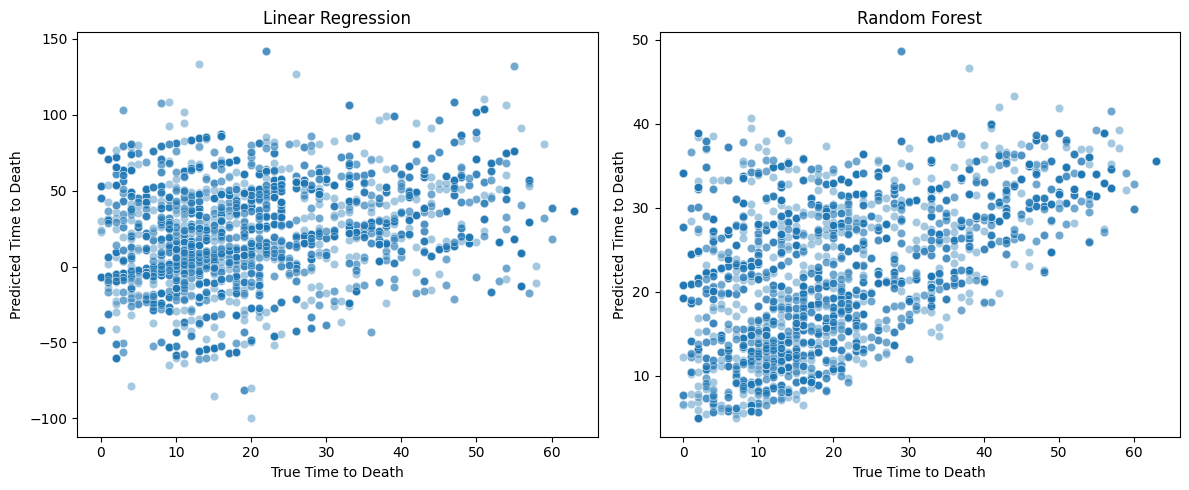

In [ ]:
# --- 📊 EVALUATE ---
def report(model_name, y_true, y_pred):
    print(f"\n📊 {model_name} — R²: {r2_score(y_true, y_pred):.3f}, MAE: {mean_absolute_error(y_true, y_pred):.2f}")

report("Linear Regression", y_test, lr.predict(X_test))
report("Random Forest", y_test, rf.predict(X_test))

# --- 📈 PLOTS ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=lr.predict(X_test), alpha=0.4)
plt.xlabel("True Time to Death"); plt.ylabel("Predicted Time to Death"); plt.title("Linear Regression")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=rf.predict(X_test), alpha=0.4)
plt.xlabel("True Time to Death"); plt.ylabel("Predicted Time to Death"); plt.title("Random Forest")

plt.tight_layout()
plt.show()


📊 Linear Regression (Test) — R²: -4.066, MAE: 25.91

📊 Linear Regression (Train) — R²: 0.995, MAE: 0.11

📊 Random Forest (Test) — R²: 0.249, MAE: 10.16

📊 Random Forest (Train) — R²: 0.995, MAE: 0.31


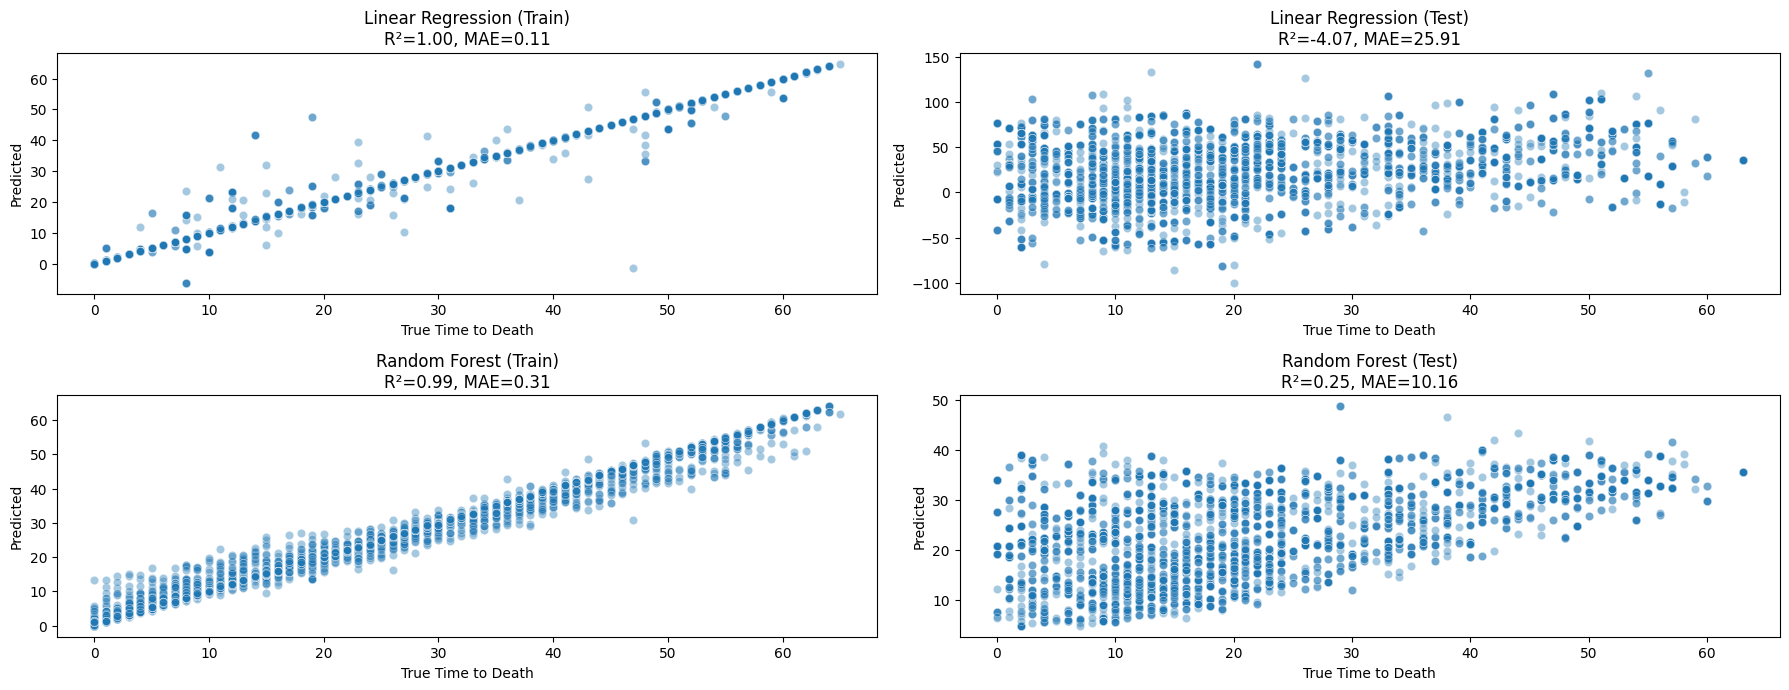

In [ ]:

# --- 📊 EVALUATE ---
def report(model_name, y_true, y_pred):
    print(f"\n📊 {model_name} — R²: {r2_score(y_true, y_pred):.3f}, MAE: {mean_absolute_error(y_true, y_pred):.2f}")

models = {
    "Linear Regression": lr,
    "Random Forest": rf}

for name, model in models.items():
    report(name + " (Test)", y_test, model.predict(X_test))
    report(name + " (Train)", y_train, model.predict(X_train))

# --- 📈 PLOTS ---
plt.figure(figsize=(18, 10))

for i, (name, model) in enumerate(models.items()):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    plt.subplot(3, 2, 2*i+1)
    sns.scatterplot(x=y_train, y=y_pred_train, alpha=0.4)
    r2_train = r2_score(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    plt.xlabel("True Time to Death")
    plt.ylabel("Predicted")
    plt.title(f"{name} (Train)\nR²={r2_train:.2f}, MAE={mae_train:.2f}")

    plt.subplot(3, 2, 2*i+2)
    sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.4)
    r2_test = r2_score(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    plt.xlabel("True Time to Death")
    plt.ylabel("Predicted")
    plt.title(f"{name} (Test)\nR²={r2_test:.2f}, MAE={mae_test:.2f}")

plt.tight_layout()
plt.show()

In [ ]:
# --- 📦 LIBRARIES ---
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, r2_score

# --- 📂 PATHS ---
metadata_path = "/content/drive/MyDrive/Gladyshev/data/master_metadata_with_gender.csv"
image_dir = "/content/drive/MyDrive/Gladyshev/data/imdb_crop_filtered_final_unzip"

# --- 📋 LOAD METADATA ---
df_meta = pd.read_csv(metadata_path)
df_meta = df_meta.drop(columns=["image_file"], errors="ignore")
df_meta = df_meta.dropna(subset=["imdb_id", "time_to_death_at_face"])
df_meta["imdb_id"] = df_meta["imdb_id"].astype(str)

print(f"✅ Metadata loaded: {df_meta.shape[0]} images across {df_meta.shape[1]} features")
actor_counts = df_meta["imdb_id"].value_counts()
print(f"🎭 Total Unique Actors: {df_meta['imdb_id'].nunique()}")
print(f"📸 Total Images: {df_meta.shape[0]}")
print(f"📊 Avg Images/Actor: {actor_counts.mean():.2f}, Median: {actor_counts.median()}, Min: {actor_counts.min()}, Max: {actor_counts.max()}, Std: {actor_counts.std():.2f}")

# --- ⚙️ ENCODER FOR CAUSE OF DEATH ---
df_meta["cause_of_death"] = df_meta["cause_of_death"].fillna("unknown")
cause_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
cause_encoder.fit(df_meta[["cause_of_death"]].values)

# --- 🖼️ MATCH ALL IMAGES PER METADATA ROW ---
image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]
images_by_id = defaultdict(list)
for f in image_files:
    imdb_id = f.split("_")[0]
    images_by_id[imdb_id].append(f)

image_records = []
for _, row in tqdm(df_meta.iterrows(), total=len(df_meta), desc="🔄 All matching images per metadata row"):
    imdb_id = row["imdb_id"]
    if imdb_id in images_by_id:
        for image_file in images_by_id[imdb_id]:
            image_records.append({
                **row.to_dict(),
                "image_file": image_file
            })

df_images = pd.DataFrame(image_records)
print(f"✅ Matched {len(df_images)} metadata-image rows across {df_images['imdb_id'].nunique()} actors")

# --- 🪠 IMAGE + METADATA FEATURE CONSTRUCTION (Sequential) ---
def load_image_and_features(row, size=(64, 64)):
    try:
        img_path = os.path.join(image_dir, row["image_file"])
        img = Image.open(img_path).convert("L").resize(size)
        img_array = np.array(img).flatten()

        age_face = row["age_at_face"] or 0
        gender = str(row.get("gender", "")).lower()
        gender_encoded = 1 if gender == "female" else 0
        cause_vector = cause_encoder.transform([[row["cause_of_death"]]]).flatten()
        metadata = np.array([age_face, gender_encoded])
        full_features = np.concatenate([img_array, metadata, cause_vector])
        return full_features, row["time_to_death_at_face"]
    except:
        return None, None

print("📸 Loading and processing images sequentially...")
X, y = [], []
for _, row in tqdm(df_images.iterrows(), total=len(df_images)):
    features, target = load_image_and_features(row)
    if features is not None:
        X.append(features)
        y.append(target)

X = np.array(X)
y = np.array(y)
print(f"✅ Final dataset: {len(X)} usable samples")

# --- 🔄 NORMALIZE NUMERIC METADATA (last 2 before cause_of_death one-hot) ---
n_cause = cause_encoder.transform([["unknown"]]).shape[1]
scaler = StandardScaler()
X[:, -2 - n_cause : -n_cause] = scaler.fit_transform(X[:, -2 - n_cause : -n_cause])

print(f"✅ Final feature matrix: {X.shape[0]} samples × {X.shape[1]} features")

# --- 🔀 SPLIT BY ACTOR ---
splitter = GroupShuffleSplit(test_size=0.2, random_state=42)
groups = df_images["imdb_id"].values
train_idx, test_idx = next(splitter.split(X, y, groups=groups))
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# --- 🤖 TRAIN MODELS ---
lr = LinearRegression().fit(X_train, y_train)
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1).fit(X_train, y_train)

# --- 📊 EVALUATE ---
def report(model_name, y_true, y_pred):
    print(f"\n📊 {model_name} — R²: {r2_score(y_true, y_pred):.3f}, MAE: {mean_absolute_error(y_true, y_pred):.2f}")

report("Linear Regression", y_test, lr.predict(X_test))
report("Random Forest", y_test, rf.predict(X_test))

# --- 📈 PLOTS ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=lr.predict(X_test), alpha=0.4)
plt.xlabel("True Time to Death"); plt.ylabel("Predicted Time to Death"); plt.title("Linear Regression")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=rf.predict(X_test), alpha=0.4)
plt.xlabel("True Time to Death"); plt.ylabel("Predicted Time to Death"); plt.title("Random Forest")

plt.tight_layout()
plt.show()


✅ Metadata loaded: 29001 images across 7 features
🎭 Total Unique Actors: 2903
📸 Total Images: 29001
📊 Avg Images/Actor: 9.99, Median: 3.0, Min: 1, Max: 540, Std: 24.02


🔄 All matching images per metadata row: 100%|██████████| 29001/29001 [00:25<00:00, 1150.49it/s]


✅ Matched 1743541 metadata-image rows across 2254 actors
📸 Loading and processing images sequentially...


 16%|█▋        | 283698/1743541 [1:06:59<32:59:15, 12.29it/s]

✅ Metadata loaded: 29001 rows across 7 features


🔄 Matching images to metadata: 100%|██████████| 29001/29001 [02:37<00:00, 183.99it/s]


✅ Matched 23509 metadata rows with images
📸 Loading and processing images sequentially...


100%|██████████| 23509/23509 [36:48<00:00, 10.64it/s]


✅ Final dataset: 23509 usable samples
✅ Final feature matrix: 23509 samples × 4436 features

📊 Linear Regression — R²: -278.460, MAE: 179.80

📊 Random Forest — R²: 0.128, MAE: 10.46


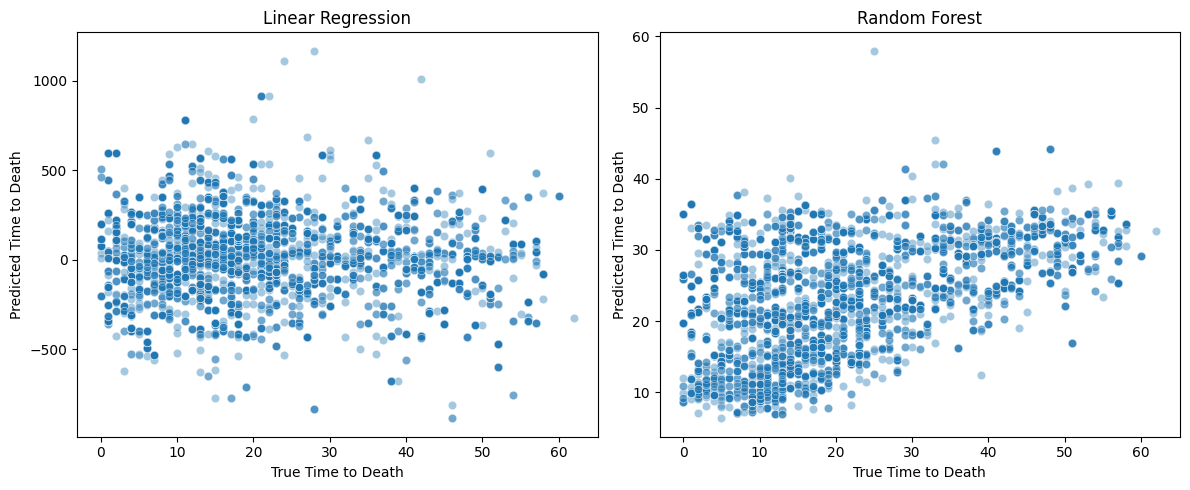

In [ ]:
# --- 📦 LIBRARIES ---
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re

from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, r2_score

# --- 📂 PATHS ---
metadata_path = "/content/drive/MyDrive/Gladyshev/data/master_metadata_with_gender.csv"
image_dir = "/content/drive/MyDrive/Gladyshev/data/imdb_crop_filtered_final_unzip"

# --- 📋 LOAD METADATA ---
df_meta = pd.read_csv(metadata_path)
df_meta = df_meta.drop(columns=["image_file"], errors="ignore")
df_meta = df_meta.dropna(subset=["imdb_id", "time_to_death_at_face", "age_at_face"])
df_meta["imdb_id"] = df_meta["imdb_id"].astype(str)

print(f"✅ Metadata loaded: {df_meta.shape[0]} rows across {df_meta.shape[1]} features")

# --- ⚙️ ENCODER FOR CAUSE OF DEATH ---
df_meta["cause_of_death"] = df_meta["cause_of_death"].fillna("unknown")
cause_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
cause_encoder.fit(df_meta[["cause_of_death"]].values)

# --- 🖼️ PARSE IMAGE FILENAMES ---
def extract_image_info(fname):
    try:
        match = re.match(r"(nm\d+)_.*_(\d{4})-(\d{1,2})-(\d{1,2})_(\d{4})\.jpg", fname)
        if not match:
            return None
        imdb_id, y, m, d, photo_year = match.groups()
        dob = datetime(int(y), int(m), int(d))
        age_at_face = int(photo_year) - dob.year
        return {
            "imdb_id": imdb_id,
            "photo_year": int(photo_year),
            "dob": dob,
            "age_at_face": age_at_face,
            "image_file": fname
        }
    except:
        return None

image_data = [extract_image_info(f) for f in os.listdir(image_dir) if f.endswith(".jpg")]
image_data = [d for d in image_data if d is not None]
df_imgs = pd.DataFrame(image_data)

# --- 🔄 MATCH IMAGES TO METADATA ROWS BY IMDB ID AND CLOSEST AGE ---
matched = []
for _, row in tqdm(df_meta.iterrows(), total=len(df_meta), desc="🔄 Matching images to metadata"):
    subset = df_imgs[df_imgs["imdb_id"] == row["imdb_id"]].copy()
    if subset.empty:
        continue
    subset["age_diff"] = np.abs(subset["age_at_face"] - row["age_at_face"])
    closest = subset[subset["age_diff"] <= 1].sort_values("age_diff").head(1)
    if not closest.empty:
        matched.append({**row.to_dict(), "image_file": closest["image_file"].values[0]})

df_images = pd.DataFrame(matched)
print(f"✅ Matched {len(df_images)} metadata rows with images")

# --- 🪠 SEQUENTIAL IMAGE + METADATA FEATURE CONSTRUCTION ---
def load_image_and_features(row, size=(64, 64)):
    try:
        img_path = os.path.join(image_dir, row["image_file"])
        img = Image.open(img_path).convert("L").resize(size)
        img_array = np.array(img).flatten()

        age_face = row["age_at_face"]
        gender = str(row.get("gender", "")).lower()
        gender_encoded = 1 if gender == "female" else 0
        cause_vector = cause_encoder.transform([[row["cause_of_death"]]]).flatten()
        metadata = np.array([age_face, gender_encoded])
        full_features = np.concatenate([img_array, metadata, cause_vector])
        return full_features, row["time_to_death_at_face"]
    except:
        return None, None

print("📸 Loading and processing images sequentially...")
X, y = [], []
for _, row in tqdm(df_images.iterrows(), total=len(df_images)):
    features, target = load_image_and_features(row)
    if features is not None:
        X.append(features)
        y.append(target)

X = np.array(X)
y = np.array(y)
print(f"✅ Final dataset: {len(X)} usable samples")

# --- 🔄 NORMALIZE NUMERIC METADATA (last 2 before cause_of_death one-hot) ---
n_cause = cause_encoder.transform([["unknown"]]).shape[1]
scaler = StandardScaler()
X[:, -2 - n_cause : -n_cause] = scaler.fit_transform(X[:, -2 - n_cause : -n_cause])

print(f"✅ Final feature matrix: {X.shape[0]} samples × {X.shape[1]} features")

# --- 🔀 SPLIT BY ACTOR ---
splitter = GroupShuffleSplit(test_size=0.2, random_state=42)
groups = df_images["imdb_id"].values
train_idx, test_idx = next(splitter.split(X, y, groups=groups))
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# --- 🤖 TRAIN MODELS ---
lr = LinearRegression().fit(X_train, y_train)
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1).fit(X_train, y_train)

# --- 📊 EVALUATE ---
def report(model_name, y_true, y_pred):
    print(f"\n📊 {model_name} — R²: {r2_score(y_true, y_pred):.3f}, MAE: {mean_absolute_error(y_true, y_pred):.2f}")

report("Linear Regression", y_test, lr.predict(X_test))
report("Random Forest", y_test, rf.predict(X_test))

# --- 📈 PLOTS ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=lr.predict(X_test), alpha=0.4)
plt.xlabel("True Time to Death"); plt.ylabel("Predicted Time to Death"); plt.title("Linear Regression")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=rf.predict(X_test), alpha=0.4)
plt.xlabel("True Time to Death"); plt.ylabel("Predicted Time to Death"); plt.title("Random Forest")

plt.tight_layout()
plt.show()


In [ ]:
# Check if 'age_at_death' was ever included
included_cols = df_images.columns[df_images.columns.isin(['age_at_death'])]
print("✅ Included columns with 'age_at_death':", included_cols.tolist())

✅ Included columns with 'age_at_death': ['age_at_death']


In [ ]:
row = df_images.iloc[0]
features, _ = load_image_and_features(row)

print("Feature vector length:", len(features))
print("Image length:", 64 * 64)
print("Cause of death one-hot length:", len(cause_encoder.transform([["unknown"]])[0]))
print("Other metadata length:", 2)  # age_at_face + gender
print("Total expected:", 64*64 + 2 + len(cause_encoder.transform([["unknown"]])[0]))


Feature vector length: 4436
Image length: 4096
Cause of death one-hot length: 338
Other metadata length: 2
Total expected: 4436


In [ ]:
# Unzip valid (features, target) pairs
X = np.array(X)
y = np.array(y)

print(f"✅ Final dataset: {len(X)} usable samples")
print(f"✅ Final feature matrix: {X.shape[0]} samples × {X.shape[1]} features")

✅ Final dataset: 23509 usable samples
✅ Final feature matrix: 23509 samples × 4436 features


In [ ]:
from sklearn.model_selection import StratifiedGroupKFold

# --- ⛓️ BIN TIME TO DEATH FOR STRATIFICATION ---
# Bin into 10 equal-width intervals (or adjust `n_bins` as needed)
n_bins = 10
bins = pd.qcut(y, q=n_bins, labels=False, duplicates='drop')  # quantile-based bins
groups = df_images["imdb_id"].values

# --- 🔀 STRATIFIED SPLIT ---
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, test_idx in sgkf.split(X, bins, groups):
    break  # Use the first split

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
print(f"✅ Train size: {len(train_idx)} — Test size: {len(test_idx)}")


✅ Train size: 18144 — Test size: 5365



📊 Linear Regression — R²: -342.971, MAE: 203.90

📊 Random Forest — R²: 0.241, MAE: 10.14


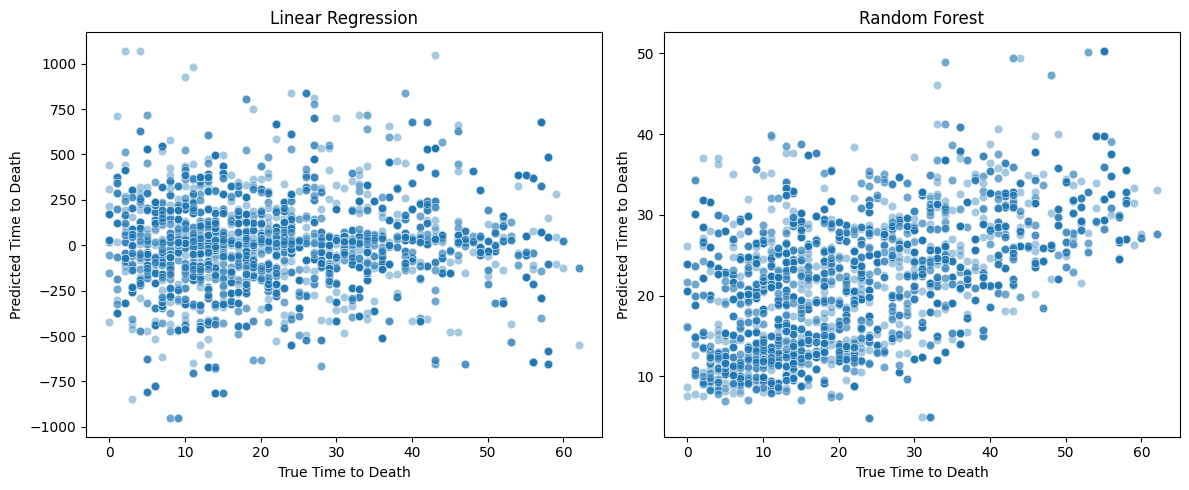

In [ ]:
# --- 🤖 TRAIN MODELS ---
lr = LinearRegression().fit(X_train, y_train)
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1).fit(X_train, y_train)

# --- 📊 EVALUATE ---
def report(model_name, y_true, y_pred):
    print(f"\n📊 {model_name} — R²: {r2_score(y_true, y_pred):.3f}, MAE: {mean_absolute_error(y_true, y_pred):.2f}")

report("Linear Regression", y_test, lr.predict(X_test))
report("Random Forest", y_test, rf.predict(X_test))

# --- 📈 PLOTS ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=lr.predict(X_test), alpha=0.4)
plt.xlabel("True Time to Death"); plt.ylabel("Predicted Time to Death"); plt.title("Linear Regression")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=rf.predict(X_test), alpha=0.4)
plt.xlabel("True Time to Death"); plt.ylabel("Predicted Time to Death"); plt.title("Random Forest")

plt.tight_layout()
plt.show()


In [ ]:
def plot_predictions(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, s=10, c='black', marker='s', alpha=0.5, label='Predicted')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', label='1-to-1 Line')
    plt.xlabel("True Time to Death")
    plt.ylabel("Predicted Time to Death")
    plt.title(f"{model_name}\nR² = {r2:.3f}, MAE = {mae:.2f}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- 📈 PLOT BOTH MODELS ---
plot_predictions(y_test, lr.predict(X_test), "Linear Regression")
plot_predictions(y_test, rf.predict(X_test), "Random Forest")

In [4]:
from google.colab import auth
from googleapiclient.discovery import build
import re

# 1. Authenticate and build the Drive API service
auth.authenticate_user()
drive_service = build('drive', 'v3')

# 2. Set the target folder ID (get this from the folder's URL in Google Drive)
FOLDER_ID = '1QPPkuF56-h55SPLVGBrzLGf25Okte8te'  # ← Replace with your folder ID

# 3. Search for files in the folder
query = f"'{FOLDER_ID}' in parents and trashed = false"
response = drive_service.files().list(q=query, fields="files(id, name)").execute()

# 4. Filter and delete files starting with 'nm'
deleted_files = []
for file in response.get('files', []):
    if file['name'].lower().startswith("nm"):
        drive_service.files().update(fileId=file['id'], body={'trashed': True}).execute()
        deleted_files.append(file['name'])

# 5. Show results
print(f"Deleted {len(deleted_files)} file(s) starting with 'nm':")
for name in deleted_files:
    print("-", name)


Deleted 94 file(s) starting with 'nm':
- nm0604702_rm3314850304_1915-4-10_1972.jpg
- nm0604702_rm3281295872_1915-4-10_1972.jpg
- nm0603402_rm3479157504_1928-1-23_1965.jpg
- nm0603402_rm3311385344_1928-1-23_1965.jpg
- nm0603402_rm3261053696_1928-1-23_1965.jpg
- nm0005502_rm960925440_1985-10-11_2010.jpg
- nm0005502_rm555129600_1985-10-11_2004.jpg
- nm0005502_rm40938496_1985-10-11_2012.jpg
- nm0005502_rm3999302656_1985-10-11_2004.jpg
- nm0005502_rm3942091008_1985-10-11_2009.jpg
- nm0005502_rm39098880_1985-10-11_2005.jpg
- nm0005502_rm3695546112_1985-10-11_2010.jpg
- nm0005502_rm3678768896_1985-10-11_2010.jpg
- nm0005502_rm355506944_1985-10-11_2001.jpg
- nm0005502_rm3479551744_1985-10-11_2011.jpg
- nm0005502_rm3429220096_1985-10-11_2011.jpg
- nm0005502_rm3424426752_1985-10-11_2006.jpg
- nm0005502_rm3354171392_1985-10-11_2004.jpg
- nm0005502_rm3324414720_1985-10-11_2009.jpg
- nm0005502_rm3147087360_1985-10-11_2011.jpg
- nm0005502_rm3114120704_1985-10-11_2007.jpg
- nm0005502_rm3090848512_198

In [5]:
from google.colab import auth
from googleapiclient.discovery import build

# 1. Authenticate and build the Drive API service
auth.authenticate_user()
drive_service = build('drive', 'v3')

# 2. Set the 'data' folder ID
FOLDER_ID = '1QPPkuF56-h55SPLVGBrzLGf25Okte8te'  # Replace with your folder ID

# 3. Query files directly inside the 'data' folder (not subfolders)
query = f"'{FOLDER_ID}' in parents and trashed = false"
deleted_files = []
page_token = None

# 4. Loop through pages
while True:
    response = drive_service.files().list(
        q=query,
        fields="nextPageToken, files(id, name, mimeType)",
        pageToken=page_token
    ).execute()

    for file in response.get('files', []):
        # Skip folders
        if file['mimeType'] == 'application/vnd.google-apps.folder':
            continue
        # Delete if name starts with 'nm'
        if file['name'].lower().startswith("nm"):
            drive_service.files().update(fileId=file['id'], body={'trashed': True}).execute()
            deleted_files.append(file['name'])

    page_token = response.get('nextPageToken')
    if not page_token:
        break

# 5. Print results
print(f"Deleted {len(deleted_files)} file(s) starting with 'nm' directly in 'data' folder:")
for name in deleted_files:
    print("-", name)

Deleted 1327 file(s) starting with 'nm' directly in 'data' folder:
- nm0001702_rm3896424704_1932-11-10_1975.jpg
- nm0001702_rm2621164544_1932-11-10_1978.jpg
- nm0001702_rm2419837952_1932-11-10_1978.jpg
- nm0001702_rm2302397440_1932-11-10_1978.jpg
- nm0001702_rm1031982592_1932-11-10_1976.jpg
- nm0001702_rm1028495616_1932-11-10_1975.jpg
- nm0001402_rm141919488_1942-2-1_1989.jpg
- nm0322002_rm576029696_1945-7-10_1974.jpg
- nm0604702_rm3667447296_1915-4-10_1978.jpg
- nm0603402_rm964735488_1928-1-23_1962.jpg
- nm0603402_rm3244276480_1928-1-23_1965.jpg
- nm0603402_rm2873342720_1928-1-23_1964.jpg
- nm0603402_rm2867434752_1928-1-23_2008.jpg
- nm0005502_rm997239808_1985-10-11_2012.jpg
- nm0005502_rm95456768_1985-10-11_2009.jpg
- nm0005502_rm78679552_1985-10-11_2009.jpg
- nm0005502_rm760257280_1985-10-11_2002.jpg
- nm0005502_rm532784896_1985-10-11_2013.jpg
- nm0005502_rm463187200_1985-10-11_2005.jpg
- nm0005502_rm441031424_1985-10-11_2000.jpg
- nm0005502_rm424254208_1985-10-11_2000.jpg
- nm00055

In [8]:
import joblib

# If files are uploaded via `files.upload()` or mounted from Drive:
# from google.colab import files
# uploaded = files.upload()

# Load pickled files
X_train = joblib.load("/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/X_train.pkl")
X_test = joblib.load("/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/X_test.pkl")
y_train = joblib.load("/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/y_train.pkl")
y_test = joblib.load("/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/y_test.pkl")
best_rf = joblib.load("/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/best_rf.pkl")
best_xgb = joblib.load("/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/best_xgb.pkl")
df_meta = joblib.load("/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/df_meta.pkl")

# Optional: confirm successful loading
print("Loaded:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")
print(f"df_meta: {df_meta.shape}")


Loaded:
X_train: (19734, 4436)
X_test: (3775, 4436)
y_train: (19734,)
y_test: (3775,)
df_meta: (29001, 7)


In [12]:
import numpy as np

# Concatenate X and y
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])
df_meta = df_meta.iloc[:len(X)].reset_index(drop=True)


In [13]:
# --- 🧠 Check cause of death one-hot columns ---
cause_cols = [col for col in df_meta.columns if col.startswith("cause_of_death_")]
time_col = "time_to_death_at_face"

print(f"Total features in X: {X.shape[1]}")
print(f"Number of cause_of_death one-hot columns: {len(cause_cols)}")
print(f"Cause of death columns: {cause_cols[:5]}{'...' if len(cause_cols) > 5 else ''}")
print(f"Index range in X (if included): [-{len(cause_cols)}:]")

# --- 🔍 Check last few columns of X against df_meta ---
print("\nSample last row of X:")
print(X[0, -len(cause_cols):])  # should match one-hot if included

print("\nCorresponding one-hot from df_meta:")
print(df_meta[cause_cols].iloc[0].values)

# --- ⏱ Check time_to_death ---
print(f"\nTime-to-death column in df_meta: {time_col}")
print(f"Sample value from df_meta: {df_meta[time_col].iloc[0]}")

# If you suspect it's in X:
print(f"Value from X[:, -1]: {X[0, -1]}")
print(f"Value from X[:, -len(cause_cols)-1]: {X[0, -len(cause_cols)-1]}")

# --- 🧪 Compare label vector y (if used separately) ---
print(f"\nSample of y (if separate): {y[:5]}")


Total features in X: 4436
Number of cause_of_death one-hot columns: 0
Cause of death columns: []
Index range in X (if included): [-0:]

Sample last row of X:
[19. 19. 18. ...  0.  0.  0.]

Corresponding one-hot from df_meta:
[]

Time-to-death column in df_meta: time_to_death_at_face
Sample value from df_meta: 20
Value from X[:, -1]: 0.0
Value from X[:, -len(cause_cols)-1]: 0.0

Sample of y (if separate): [16 33 11 29  5]


In [14]:
n_img = 64 * 64  # grayscale flattened
n_cause = cause_encoder.transform([["unknown"]]).shape[1]

print(f"Total features in X: {X.shape[1]}")
print(f"Image features: {n_img}")
print(f"Age & gender: 2")
print(f"Cause of death (one-hot): {n_cause}")
print(f"Expected total: {n_img + 2 + n_cause}")


NameError: name 'cause_encoder' is not defined